In [1]:
import os
import random
import numpy as np
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import r2_score
from tqdm import tqdm
from termcolor import colored

In [2]:
# Custom dataset class for dSprites dataset
class DspritesDataset(Dataset):
    def __init__(self, npz_file):
        """
        Initialize the dSprites dataset by loading the image data and ground truth factors.

        Args:
            npz_file (str): Path to the .npz file containing the dataset.
        """
        self.data = np.load(npz_file)
        self.images = np.expand_dims(self.data['imgs'], axis=1)
        self.latent_classes = self.data['latents_classes'][:, 1:]  # Skip the 'color' factor (always 1)
        self.latent_values = self.data['latents_values'][:, 1:]  # Skip the 'color' factor (always 1)

    def __len__(self):
        """Returns the total number of images."""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Fetch an image and its corresponding ground truth factors.

        Args:
            idx (int): Index of the data sample.

        Returns:
            Tuple: Image as torch.Tensor, latent classes, and latent values.
        """
        image = torch.tensor(self.images[idx], dtype=torch.float32)  # Convert image to float32 tensor
        latent_classes = torch.tensor(self.latent_classes[idx], dtype=torch.int)  # Discrete factors
        latent_values = torch.tensor(self.latent_values[idx], dtype=torch.float32)  # Continuous factors

        return image, latent_classes, latent_values

# Encoder architecture
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        """
        Encoder for beta-VAE using convolutional layers.

        Args:
            latent_dim (int): Dimensionality of the latent space.
        """
        super(ConvEncoder, self).__init__()
        # Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU()
        )
        # Fully connected layers for mu and logvar
        self.fc1 = nn.Linear(64 * 4 * 4, 256)  # Fully connected layer with 256 units
        self.fc_mu = nn.Linear(256, latent_dim)  # Latent mean
        self.fc_logvar = nn.Linear(256, latent_dim)  # Latent log-variance

    def forward(self, x):
        """
        Forward pass for the encoder to produce latent space parameters.

        Args:
            x (torch.Tensor): Input image.

        Returns:
            mu (torch.Tensor): Mean of the latent space.
            logvar (torch.Tensor): Log-variance of the latent space.
        """
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten the output of the convolution layers
        h = self.fc1(h)  # Apply fully connected layer
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Decoder architecture
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim, num_channels=1):
        """
        Decoder for beta-VAE using transpose convolutional layers.

        Args:
            latent_dim (int): Dimensionality of the latent space.
            num_channels (int): Number of output image channels (1 for grayscale images).
        """
        super(ConvDecoder, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(latent_dim, 256)  # Latent dim -> 256
        self.fc2 = nn.Linear(256, 64 * 4 * 4)  # 256 -> 4x4x64
        
        # Transpose convolutional layers with adjusted padding
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, num_channels, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Sigmoid()
        )
    
    def forward(self, z):
        """
        Forward pass for the decoder to reconstruct the image from the latent space.

        Args:
            z (torch.Tensor): Latent vector.

        Returns:
            torch.Tensor: Reconstructed image.
        """
        h = self.fc1(z)
        h = self.fc2(h)
        h = h.view(h.size(0), 64, 4, 4)  # Reshape to match convolutional layers
        return self.decoder(h)

# beta-VAE model
class BetaVAE(nn.Module):
    def __init__(self, latent_dim):
        """
        beta-VAE model with encoder and decoder networks.

        Args:
            latent_dim (int): Dimensionality of the latent space.
        """
        super(BetaVAE, self).__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from a Gaussian distribution.

        Args:
            mu (torch.Tensor): Mean of the latent space.
            logvar (torch.Tensor): Log-variance of the latent space.

        Returns:
            torch.Tensor: Reparameterized latent vector.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Random normal noise
        return mu + eps * std

    def forward(self, x):
        """
        Forward pass for the entire VAE model.

        Args:
            x (torch.Tensor): Input image.

        Returns:
            recon_x (torch.Tensor): Reconstructed image.
            mu (torch.Tensor): Mean of the latent space.
            logvar (torch.Tensor): Log-variance of the latent space.
        """
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [3]:
def beta_vae_loss(X_hat, X, Z_mu, Z_logvar, beta):
    """
    Compute the total loss for beta-VAE.

    Args:
        X_hat (torch.Tensor): Reconstructed input (output of the decoder).
        X (torch.Tensor): Original input.
        Z_mu (torch.Tensor): Mean of the latent distribution.
        Z_logvar (torch.Tensor): Log-variance of the latent distribution.
        beta (float): Weight for the KL divergence term.

    Returns:
        bce_loss (torch.Tensor): Binary cross-entropy loss (summed over the batch).
        kl_loss (torch.Tensor): KL divergence loss (summed over the batch).
        total_loss (torch.Tensor): Total loss (bce_loss + beta * kl_loss).
    """
    # Binary cross-entropy loss
    bce_loss = F.binary_cross_entropy(X_hat, X, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + Z_logvar - Z_mu.pow(2) - Z_logvar.exp())

    # Total loss
    total_loss = bce_loss + beta * kl_loss

    return bce_loss, kl_loss, total_loss

def train_beta_vae(model, train_loader, val_loader, optimizer, loss_fn, beta, device, num_epochs):
    """
    Train the beta-VAE model.
    """
    # Initialize loss histories
    train_loss_hist, val_loss_hist = [], []
    kl_loss_hist, val_kl_loss_hist = [], []
    bce_loss_hist, val_bce_loss_hist = [], []

    for epoch in range(num_epochs):
        # --- Training Step ---
        model.train()
        train_loss, kl_loss, bce_loss = 0, 0, 0

        for batch, _, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            batch = batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            X_hat, Z_mu, Z_logvar = model(batch)

            # Compute loss
            bce_loss_batch, kl_loss_batch, total_loss_batch = loss_fn(X_hat, batch, Z_mu, Z_logvar, beta)

            # Backward pass
            total_loss_batch.backward()
            optimizer.step()

            # Accumulate batch losses
            train_loss += total_loss_batch.item()
            kl_loss += kl_loss_batch.item()
            bce_loss += bce_loss_batch.item()

        num_samples = len(train_loader.dataset)
        train_loss_hist.append(train_loss / num_samples)
        kl_loss_hist.append(kl_loss / num_samples)
        bce_loss_hist.append(bce_loss / num_samples)

        # --- Validation Step ---
        model.eval()
        val_loss, val_kl_loss, val_bce_loss = 0, 0, 0

        with torch.no_grad():
            for batch, _, _ in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                batch = batch.to(device)

                # Forward pass
                X_hat, Z_mu, Z_logvar = model(batch)

                # Compute loss
                bce_loss_batch, kl_loss_batch, total_loss_batch = loss_fn(X_hat, batch, Z_mu, Z_logvar, beta)

                # Accumulate batch losses
                val_loss += total_loss_batch.item()
                val_kl_loss += kl_loss_batch.item()
                val_bce_loss += bce_loss_batch.item()

        num_samples = len(val_loader.dataset)
        val_loss_hist.append(val_loss / num_samples)
        val_kl_loss_hist.append(val_kl_loss / num_samples)
        val_bce_loss_hist.append(val_bce_loss / num_samples)

        # --- Logging the losses ---
        print(f"Epoch [{epoch+1}/{num_epochs}] Train BCE: {bce_loss_hist[-1]:.4f}, KL: {kl_loss_hist[-1]:.4f}, Total: {train_loss_hist[-1]:.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}] Val BCE: {val_bce_loss_hist[-1]:.4f}, KL: {val_kl_loss_hist[-1]:.4f}, Total: {val_loss_hist[-1]:.4f}")

    return {
        'train_loss': train_loss_hist,
        'val_loss': val_loss_hist,
        'kl_loss': kl_loss_hist,
        'val_kl_loss': val_kl_loss_hist,
        'bce_loss': bce_loss_hist,
        'val_bce_loss': val_bce_loss_hist
    }

In [4]:
# Function to select exactly 3 distinct shape indices
def select_3_distinct_shape_indices(dataset, split_indices):
    """
    Select one index for each distinct shape (square, ellipse, heart).

    Args:
    - dataset: The dataset containing images and latent classes.
    - split_indices: The indices corresponding to the data split (train, validation, etc.).

    Returns:
    - distinct_shape_indices: A list containing one randomly selected index for each distinct shape.
    """
    # Dictionary to store indices for each shape
    shape_indices = {0: [], 1: [], 2: []}
    
    # Iterate over the split indices to collect indices for each shape
    for idx in split_indices:
        _, latent_classes, _ = dataset[idx]
        shape_class = latent_classes[0].item()  # Shape class: 0 = square, 1 = ellipse, 2 = heart
        
        # Add the index to the corresponding shape list
        shape_indices[shape_class].append(idx)
    
    # Print the number of images for each shape
    shape_names = {0: 'square', 1: 'ellipse', 2: 'heart'}
    for shape_class, indices in shape_indices.items():
        print(f"Number of {shape_names[shape_class]} images: {len(indices)}")
    
    # Randomly select one index from each shape class
    distinct_shape_indices = [random.choice(shape_indices[shape]) for shape in range(3)]
    
    return distinct_shape_indices

def visualize_3_images_from_shapes(dataset, distinct_shape_indices):
    """
    Visualize 3 images corresponding to distinct shapes (square, ellipse, heart) and save them.

    Args:
    - dataset: The dataset containing images and latent classes.
    - distinct_shape_indices: A list of 3 indices corresponding to distinct shape images.
    """
    # Ensure exactly 3 indices are provided
    if len(distinct_shape_indices) != 3:
        raise ValueError("distinct_shape_indices must contain exactly 3 indices.")
    
    # Define the shape names
    shape_names = ['square', 'ellipse', 'heart']
    
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Iterate through the indices, display, and save the images
    for i, (idx, shape_name) in enumerate(zip(distinct_shape_indices, shape_names)):
        image, _, _ = dataset[idx]  # Retrieve the image at the specified index
        
        # Display the image in the subplot
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{shape_name}", fontsize=16)

        # Save each image with its corresponding shape name
        image_save_path = os.path.join(SAVE_PATH, f"{shape_name}.png")
        plt.imsave(image_save_path, image.squeeze(), cmap='gray')

    plt.tight_layout()
    plt.show()

In [5]:
# Function to plot losses for both training and validation over epochs
def plot_beta_vae_losses(train_loss_hist, val_loss_hist, kl_loss_hist, val_kl_loss_hist, recon_loss_hist, val_recon_loss_hist, beta):
    """
    Plot the total loss, KL divergence, and reconstruction error for both training and validation sets.

    Args:
    - train_loss_hist (list): History of training total losses (-ELBO).
    - val_loss_hist (list): History of validation total losses (-ELBO).
    - kl_loss_hist (list): History of training KL divergence losses.
    - val_kl_loss_hist (list): History of validation KL divergence losses.
    - recon_loss_hist (list): History of training reconstruction errors.
    - val_recon_loss_hist (list): History of validation reconstruction errors.
    - beta (float): The beta value used for the loss scaling in beta-VAE.
    """
    epochs = len(train_loss_hist)

    plt.figure(figsize=(15, 5))

    # Subplot for Total Loss (-ELBO)
    plt.subplot(1, 3, 1)
    plt.plot(range(epochs), train_loss_hist, label="Training", linestyle='-')
    plt.plot(range(epochs), val_loss_hist, label="Validation", linestyle='--')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Total Loss', fontsize=14)
    plt.xticks(ticks=[0, 20, 40, 60, 80, 100], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)

    # Subplot for KL Divergence
    plt.subplot(1, 3, 2)
    plt.plot(range(epochs), kl_loss_hist, label="Training", linestyle='-')
    plt.plot(range(epochs), val_kl_loss_hist, label="Validation", linestyle='--')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('KL Divergence', fontsize=14)
    plt.xticks(ticks=[0, 20, 40, 60, 80, 100], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)

    # Subplot for Reconstruction Error
    plt.subplot(1, 3, 3)
    plt.plot(range(epochs), recon_loss_hist, label="Training", linestyle='-')
    plt.plot(range(epochs), val_recon_loss_hist, label="Validation", linestyle='--')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('BCE Loss', fontsize=14)
    plt.xticks(ticks=[0, 20, 40, 60, 80, 100], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.3)
    plt.savefig(f"{SAVE_PATH}beta_vae_loss_plots_{beta}.png")
    plt.show()

In [6]:
# Visualization of original and reconstructed images in separate grids
def visualize_images_grid(model, data_loader, device, beta, num_images=64):
    """
    Visualize and save original and reconstructed images from a batch of data.
    
    Args:
    - model (torch.nn.Module): Trained beta-VAE model.
    - data_loader (torch.utils.data.DataLoader): DataLoader for the dataset.
    - device (torch.device): Device to run the model on (CPU or GPU).
    - beta (float): The beta value used for the loss scaling in beta-VAE.
    - num_images (int): Number of images to visualize.
    """
    model.eval()

    # Retrieve one batch of images from the data loader
    images, _, _ = next(iter(data_loader))
    images = images[:num_images]

    # Disable gradient calculations
    with torch.no_grad():
        images = images.to(device)
        mu, logvar = model.encoder(images)
        
        # Sample z using the reparameterization trick
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mu + std * epsilon

        recon_images = model.decoder(z)

    img_dim = images[0].cpu().squeeze().shape[0]

    # Create separate images for original and reconstructed images
    original_image_grid = np.ones((8 * img_dim, 8 * img_dim))  # 8 rows, 8 columns grid
    reconstructed_image_grid = np.ones((8 * img_dim, 8 * img_dim))  # 8 rows, 8 columns grid

    # Fill in the grids with images
    for i in range(8):
        for j in range(8):
            idx = i * 8 + j
            if idx < num_images:
                # Fill the original image grid
                original_image_grid[i * img_dim:(i + 1) * img_dim, j * img_dim:(j + 1) * img_dim] = images[idx].cpu().squeeze()

                # Fill the reconstructed image grid
                reconstructed_image_grid[i * img_dim:(i + 1) * img_dim, j * img_dim:(j + 1) * img_dim] = recon_images[idx].cpu().squeeze()

    # Save the original images only for the first beta = 1
    if beta == 1:
        plt.figure(figsize=(10, 10))
        plt.imshow(original_image_grid, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"{SAVE_PATH}/original_images.png", bbox_inches='tight', pad_inches=0)
        plt.close()

    # Save the reconstructed images for all betas
    plt.figure(figsize=(10, 10))
    plt.imshow(reconstructed_image_grid, cmap='gray')
    plt.axis('off')
    plt.tight_layout()

    plt.savefig(f"{SAVE_PATH}/reconstructed_images_beta_{beta}.png", bbox_inches='tight', pad_inches=0)    
    plt.close()

In [7]:
def visualize_latent_traversal_combined(model, device, gif_path, distinct_shape_indices, dataset, latent_dim=10, num_traversals=11):
    """
    Visualize latent space traversal for dSprites dataset, creating both PNG and GIF outputs.

    Args:
    - model (torch.nn.Module): Trained Beta-VAE model.
    - device (torch.device): Device to run the model on (CPU or GPU).
    - gif_path (str): Path to save the generated GIF and PNG files.
    - distinct_shape_indices (list): List of indices representing distinct shapes in the dataset.
    - dataset (Dataset): dSprites dataset object.
    - latent_dim (int): The number of latent dimensions (default=10).
    - num_traversals (int): Number of traversal steps between -2 and 2 (default=11).
    """
    model.eval()

    # Define the interpolation range (from -2 to 2)
    interpolation = torch.linspace(-2, 2, num_traversals)

    # Prepare for storing frames for the final combined GIF (3 rows x num_traversals columns)
    combined_gif_frames_all_shapes = [[] for _ in range(num_traversals)]

    # Loop through each distinct shape (3 rows in the final GIF)
    for row, idx in enumerate(distinct_shape_indices):
        image, _, _ = dataset[idx]
        image = image.unsqueeze(0).to(device)

        mu, logvar = model.encoder(image)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std      

        # Prepare for storing frames for the current shape's latent traversal
        combined_gif_frames = [[] for _ in range(num_traversals)]

        # Perform traversal for each latent dimension
        for latent_idx in range(latent_dim):
            z_ori = z.clone()  # Clone the latent vector

            # Perform interpolation across the specified latent dimension
            for i, alpha in enumerate(interpolation):
                z_copy = z_ori.clone()
                z_copy[:, latent_idx] = alpha  # Set this latent dimension to the interpolation value

                # Generate the reconstructed image using the decoder
                with torch.no_grad():
                    generated_image = model.decoder(z_copy)

                # Convert to numpy array and append the frame for saving
                gen_img = generated_image.squeeze().cpu().numpy()
                combined_gif_frames[i].append(np.uint8(255 * gen_img))

        # Create grid for latent traversals (one shape, 10 latent dimensions, 11 traversal steps)
        gif_frames_with_10_columns = [np.hstack(frame_list) for frame_list in combined_gif_frames]

        # Store frames for all shapes into the combined GIF structure
        for i in range(num_traversals):
            if row == 0:
                combined_gif_frames_all_shapes[i] = [gif_frames_with_10_columns[i]]
            else:
                combined_gif_frames_all_shapes[i].append(gif_frames_with_10_columns[i])

        # Generate and save PNG for the current shape's latent traversals
        png_output_path = f"{gif_path}_image_{row + 1}.png"
        save_png_latent_traversal_only(combined_gif_frames, png_output_path, latent_dim, num_traversals)

    # Combine frames of all shapes for the final GIF (3 rows x num_traversals columns)
    final_gif_frames = [np.vstack(frame_list) for frame_list in combined_gif_frames_all_shapes]

    # Save the final GIF combining all shapes and latent traversals
    gif_output_path = f"{gif_path}_combined.gif"
    save_combined_gif(final_gif_frames, gif_output_path)

# Helper function to save the final combined GIF (3 rows and 10 columns) with column titles
def save_combined_gif(frames, output_path):
    """
    Save the combined GIF that shows the latent traversal for multiple shapes.

    Args:
    - frames (list): List of frames to include in the GIF.
    - output_path (str): Path to save the GIF.
    """
    gif_frames_with_labels = []

    for frame in frames:
        if frame is not None and frame.size > 0:
            fig, ax = plt.subplots(figsize=(20, 6))
            ax.imshow(frame, cmap='gray', vmin=0, vmax=255)  # Display the frame in grayscale
            ax.axis('off')

            # Add column labels (x_1 to x_10) for each latent dimension
            column_labels = [f'$x_{{{i + 1}}}$' for i in range(10)]
            for i, label in enumerate(column_labels):
                x_pos = (frame.shape[1] / 10) * (i + 0.5)  # Calculate label position
                ax.text(x_pos, -10, label, fontsize=14, ha='center', va='bottom', color='black')

            # Ensure the figure is drawn before converting to an image
            fig.canvas.draw()

            # Convert the figure to an image array and append it to the list of frames
            gif_frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (4,))
            gif_frames_with_labels.append(gif_frame)
            plt.close(fig)

    # Save the GIF
    if gif_frames_with_labels:
        # Convert images to uint8
        gif_frames_with_labels = [np.uint8(frame) for frame in gif_frames_with_labels]
        imageio.mimsave(output_path, gif_frames_with_labels, fps=5, loop=0)  # loop=0 for infinite looping
    else:
        print("No valid frames to save for GIF.")

# Function to save PNG for latent traversals with row labels for each latent dimension
def save_png_latent_traversal_only(traversal_images, output_path, latent_dim=10, num_traversals=11):
    """
    Save a PNG file for visualizing the latent traversals across all dimensions.

    Args:
    - traversal_images (list): List of images generated during the traversal.
    - output_path (str): Path to save the PNG.
    - latent_dim (int): Number of latent dimensions.
    - num_traversals (int): Number of interpolation steps.
    """
    # Create a figure with tight-fitting subplots
    fig, axes = plt.subplots(latent_dim, num_traversals, figsize=(num_traversals * 2, latent_dim * 2))

    # Define the interpolation values for the column labels from -2 to 2
    interpolation_values = np.linspace(-2, 2, num_traversals)

    # Plot the traversal images in a grid for all latent dimensions
    for latent_idx in range(latent_dim):
        for frame_idx in range(num_traversals):
            axes[latent_idx, frame_idx].imshow(traversal_images[frame_idx][latent_idx], cmap='gray', aspect='auto')
            axes[latent_idx, frame_idx].axis('off')

    # Add row labels for each latent dimension (x_1 through x_10)
    row_labels = [f'$x_{{{i + 1}}}$' for i in range(latent_dim)]
    for i, label in enumerate(row_labels):
        axes[i, 0].annotate(label, xy=(-0.05, 0.5), xycoords='axes fraction', xytext=(-30, 0), textcoords='offset points',
                            ha='center', va='center', fontsize=18, color='black')

    # Add column labels for x-axis (-2 to +2)
    for frame_idx in range(num_traversals):
        axes[0, frame_idx].set_title(f'{interpolation_values[frame_idx]:.1f}', fontsize=18, color='black')

    plt.subplots_adjust(left=0.05, right=0.99, top=0.9, bottom=0.1, wspace=0, hspace=0)

    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

In [8]:
# Function to extract latent representations and ground truth factors
def extract_latents_and_factors(model, data_loader, device, flag):
    """
    Extract latent representations and ground truth factors.

    Args:
    - model (torch.nn.Module): Trained beta-VAE model.
    - data_loader (torch.utils.data.DataLoader): DataLoader object to load the dataset.
    - device (torch.device): Device to run the model on (CPU or GPU).
    - flag (int): 0 for training data, 1 for validation data.
    
    Returns:
    - latent_classes (numpy.ndarray): Discrete ground truth factors for the data.
    - latent_values (numpy.ndarray): Continuous ground truth factors for the data.
    - mu_list (numpy.ndarray): List of mean values for the latent variables.
    - std_list (numpy.ndarray): List of standard deviations for the latent variables.
    """
    model.eval()
    latent_classes_list, latent_values_list = [], []
    mu_list, std_list = [], []

    desc = 'Training' if flag == 0 else 'Validation'
    
    # No gradient computation needed during evaluation
    with torch.no_grad():
        for image, latent_classes, latent_values in tqdm(data_loader, desc=desc):
            image = image.to(device)
            
            mu, logvar = model.encoder(image)
            sigma = torch.exp(0.5 * logvar)
            
            latent_classes_list.append(latent_classes)
            latent_values_list.append(latent_values)
            mu_list.append(mu.cpu())
            std_list.append(sigma.cpu())

    latent_classes = torch.cat(latent_classes_list, dim=0).numpy()
    latent_values = torch.cat(latent_values_list, dim=0).numpy()
    mu_list = torch.cat(mu_list, dim=0).numpy()
    std_list = torch.cat(std_list, dim=0).numpy()
    
    return latent_classes, latent_values, mu_list, std_list

In [9]:
def main():
    for beta in BETAS:
        print(colored(f"\nProcessing with beta = {beta}...", "green", attrs=['bold']))
            
        # Define model and check if pre-trained weights exist
        model_save_path = os.path.join(SAVE_PATH, f'beta_vae_{beta}.pth')
        model = BetaVAE(latent_dim=LATENT_DIM).to(DEVICE)
        trained = False  # Flag to indicate whether the model was trained

        if os.path.exists(model_save_path):
            print(colored(f"Loading saved model weights for beta = {beta}...", "green", attrs=['bold']))
            model.load_state_dict(torch.load(model_save_path))
        else:
            print(colored(f"\nTraining beta-VAE with beta = {beta}...", "red", attrs=['bold']))
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
            criterion = beta_vae_loss

            # Train the model and track the losses
            train_results = train_beta_vae(model, train_loader, val_loader, optimizer, criterion, beta, DEVICE, NUM_EPOCHS)

            # Unpack the training results
            train_loss_hist = train_results['train_loss']
            val_loss_hist = train_results['val_loss']
            kl_loss_hist = train_results['kl_loss']
            val_kl_loss_hist = train_results['val_kl_loss']
            bce_loss_hist = train_results['bce_loss']
            val_bce_loss_hist = train_results['val_bce_loss']

            np.save(os.path.join(SAVE_PATH, f'train_loss_hist_beta_{beta}.npy'), train_loss_hist)
            np.save(os.path.join(SAVE_PATH, f'val_loss_hist_beta_{beta}.npy'), val_loss_hist)
            np.save(os.path.join(SAVE_PATH, f'kl_loss_hist_beta_{beta}.npy'), kl_loss_hist)
            np.save(os.path.join(SAVE_PATH, f'val_kl_loss_hist_beta_{beta}.npy'), val_kl_loss_hist)
            np.save(os.path.join(SAVE_PATH, f'bce_loss_hist_beta_{beta}.npy'), bce_loss_hist)
            np.save(os.path.join(SAVE_PATH, f'val_bce_loss_hist_beta_{beta}.npy'), val_bce_loss_hist)
            
            # Save trained model
            torch.save(model.state_dict(), model_save_path)
            trained = True

        # Extract latent and ground truth factors for both training and validation datasets
        print(colored(f"\nExtracting latent vectors and ground truth factors for beta = {beta}...", "blue", attrs=['bold']))
        latent_classes_train, latent_values_train, mu_list_train, std_list_train = extract_latents_and_factors(model, train_loader, DEVICE, 0)
        latent_classes_val, latent_values_val, mu_list_val, std_list_val = extract_latents_and_factors(model, val_loader, DEVICE, 1)

        np.save(os.path.join(SAVE_PATH, f'train_latent_classes_beta_{beta}.npy'), latent_classes_train)
        np.save(os.path.join(SAVE_PATH, f'train_latent_values_beta_{beta}.npy'), latent_values_train)
        np.save(os.path.join(SAVE_PATH, f'train_mu_beta_{beta}.npy'), mu_list_train)
        np.save(os.path.join(SAVE_PATH, f'train_std_beta_{beta}.npy'), std_list_train)
        np.save(os.path.join(SAVE_PATH, f'val_latent_classes_beta_{beta}.npy'), latent_classes_val)
        np.save(os.path.join(SAVE_PATH, f'val_latent_values_beta_{beta}.npy'), latent_values_val)
        np.save(os.path.join(SAVE_PATH, f'val_mu_beta_{beta}.npy'), mu_list_val)
        np.save(os.path.join(SAVE_PATH, f'val_std_beta_{beta}.npy'), std_list_val)

        # Plot training and validation losses
        if trained:
            print(colored(f"\nPlotting training and validation losses for beta = {beta}...", "blue", attrs=['bold']))
            plot_beta_vae_losses(train_loss_hist, val_loss_hist, kl_loss_hist, val_kl_loss_hist, bce_loss_hist, val_bce_loss_hist, beta)

        # Visualization functions
        visualize_images_grid(model, val_loader, DEVICE, beta)

        gif_path = os.path.join(SAVE_PATH, f'latent_traversal_beta_{beta}')
        visualize_latent_traversal_combined(model, DEVICE, gif_path, distinct_shape_indices, val_dataset)

In [10]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU found.")

# Set GPU 1 as the default device
torch.cuda.set_device(1)
print(f"Using GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")

GPU 0: NVIDIA RTX A5000
GPU 1: NVIDIA GeForce RTX 2080 Ti
Using GPU: NVIDIA GeForce RTX 2080 Ti


Number of square images: 24736
Number of ellipse images: 24658
Number of heart images: 24334


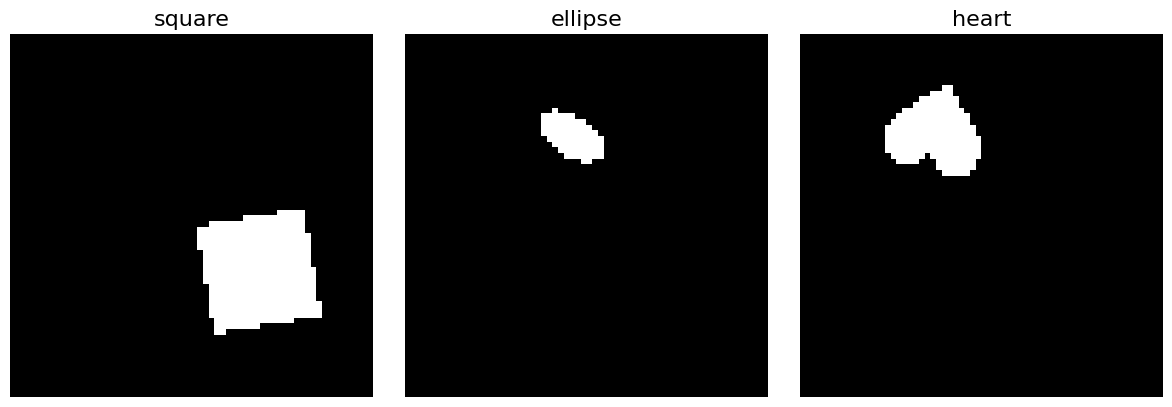

In [11]:
# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Hyperparameters and constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NPZ_FILE = "dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
SAVE_PATH = "./betaVAE_results/"
LATENT_DIM = 10  # Dimensionality of the latent space
BATCH_SIZE = 64  # Batch size for training and validation
LEARNING_RATE = 1e-4  # Learning rate for the optimizer
NUM_EPOCHS = 100  # Number of training epochs
BETAS = [0.1, 1, 2, 4, 8, 16]  # Different beta values for beta-VAE

# Load dataset
dataset = DspritesDataset(NPZ_FILE)

# Ensure the results directory exists
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Define file paths for the indices
train_indices_file = os.path.join(SAVE_PATH, "train_indices.npy")
val_indices_file = os.path.join(SAVE_PATH, "val_indices.npy")

# Split the dataset
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Check if saved indices exist for a consistent split across runs
if os.path.exists(train_indices_file) and os.path.exists(val_indices_file):
    # Load saved indices using numpy
    train_indices = np.load(train_indices_file)
    val_indices = np.load(val_indices_file)
else:
    # Save the indices for reproducibility
    train_indices, val_indices = torch.utils.data.random_split(
        range(len(dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(SEED)
    )

    # Save indices using numpy
    np.save(train_indices_file, train_indices)
    np.save(val_indices_file, val_indices)

# Create subsets using saved indices
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Select distinct shape indices (square, ellipse, heart) from the validation dataset
distinct_shape_indices = select_3_distinct_shape_indices(val_dataset, list(range(val_size)))
visualize_3_images_from_shapes(val_dataset, distinct_shape_indices)

In [ ]:
# Main script execution
if __name__ == '__main__':
    main()


Processing with beta = 0.1...

Training beta-VAE with beta = 0.1...




poch 1/100 - Validation: 100%|████████████| 1152/1152 [00:03<00:00, 369.97it/s]

Epoch [1/100] Train BCE: 116.5152, KL: 47.6044, Total: 121.2756
Epoch [1/100] Val BCE: 50.5441, KL: 40.8016, Total: 54.6243




poch 2/100 - Validation: 100%|████████████| 1152/1152 [00:03<00:00, 365.96it/s]

Epoch [2/100] Train BCE: 37.4183, KL: 43.0732, Total: 41.7256
Epoch [2/100] Val BCE: 31.0451, KL: 43.4791, Total: 35.3930




poch 3/100 - Validation: 100%|████████████| 1152/1152 [00:03<00:00, 360.45it/s]

Epoch [3/100] Train BCE: 28.9007, KL: 44.0124, Total: 33.3020
Epoch [3/100] Val BCE: 26.9959, KL: 43.8934, Total: 31.3853




poch 4/100 - Validation: 100%|████████████| 1152/1152 [00:03<00:00, 367.02it/s]

Epoch [4/100] Train BCE: 25.8772, KL: 44.2429, Total: 30.3015
Epoch [4/100] Val BCE: 24.8093, KL: 44.1584, Total: 29.2251




poch 5/100 - Validation: 100%|████████████| 1152/1152 [00:03<00:00, 353.70it/s]

Epoch [5/100] Train BCE: 23.7299, KL: 44.5157, Total: 28.1815
Epoch [5/100] Val BCE: 22.5559, KL: 44.7839, Total: 27.0342




poch 6/100 - Validation: 100%|████████████| 1152/1152 [00:03<00:00, 358.90it/s]

Epoch [6/100] Train BCE: 21.9534, KL: 44.8010, Total: 26.4335
Epoch [6/100] Val BCE: 20.9925, KL: 45.0087, Total: 25.4934




poch 7/100 - Validation: 100%|████████████| 1152/1152 [00:03<00:00, 352.55it/s]

Epoch [7/100] Train BCE: 20.5995, KL: 45.0344, Total: 25.1029
Epoch [7/100] Val BCE: 19.7606, KL: 44.8997, Total: 24.2505




poch 8/100 - Validation: 100%|████████████| 1152/1152 [00:03<00:00, 352.89it/s]

Epoch [8/100] Train BCE: 19.5189, KL: 45.1715, Total: 24.0360
Epoch [8/100] Val BCE: 18.8056, KL: 45.1800, Total: 23.3236




poch 9/100 - Validation: 100%|████████████| 1152/1152 [00:03<00:00, 350.11it/s]

Epoch [9/100] Train BCE: 18.6479, KL: 45.2285, Total: 23.1707
Epoch [9/100] Val BCE: 18.0593, KL: 45.0141, Total: 22.5607




poch 10/100 - Validation: 100%|███████████| 1152/1152 [00:03<00:00, 356.05it/s]

Epoch [10/100] Train BCE: 17.9083, KL: 45.2712, Total: 22.4354
Epoch [10/100] Val BCE: 17.3269, KL: 45.1819, Total: 21.8451


Epoch 11/100 - Training:  86%|███████████▏ | 8940/10368 [01:51<00:18, 78.72it/s]